<a href="https://colab.research.google.com/github/ahmetalkilinc/DataScienceTutorials/blob/master/BBM469_Tutorial_8_Machine_Learning_with_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BBM469-Data Intensive Applications Lab. Machine Learning with Spark**

---



**The Aim**

In this document, you will be given for some tutorials and headlines for you to learn the basics of Apache Spark.

**Apache Spark**

Apache Spark is a fast and general-purpose cluster computing system. It provides high-level APIs in Java, Scala, Python and R, and an optimized engine that supports general execution graphs. It also supports a rich set of higher-level tools including Spark SQL for SQL and structured data processing, MLlib for machine learning, GraphX for graph processing, and Spark Streaming.

Further more information: https://spark.apache.org/

**Running Pyspark in Colab**

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 2.4.7 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system. 

First, install the dependencies:

In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

 Set the location of Java and Spark by running the following code:



In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

Test your installation:

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

**Clustering Example**

**K-means**

K-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters. Further more information: https://spark.apache.org/docs/latest/ml-clustering.html

import the following libraries.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Generate some input data and write the dataset as a CSV file.

In [6]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.loc[:, cols]
pddf.head()

# save the ndarray as a csv file
pddf.to_csv('input.csv', index=False)

List your files

In [7]:
!ls

input.csv    spark-2.4.7-bin-hadoop2.7
sample_data  spark-2.4.7-bin-hadoop2.7.tgz


Visualize the data.

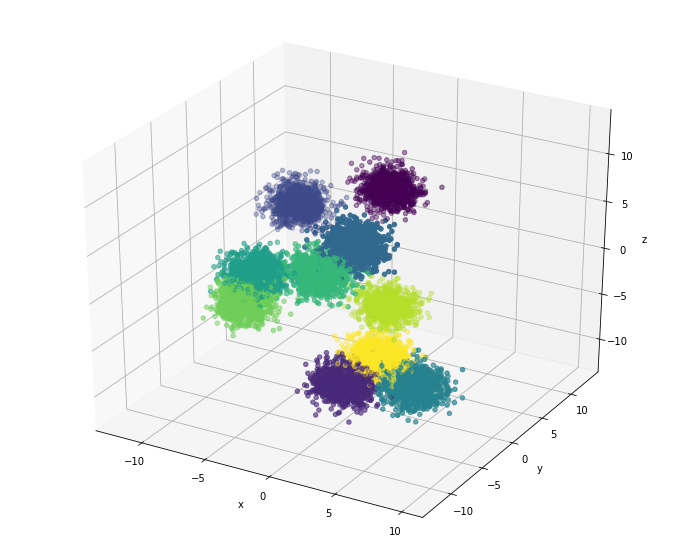

In [8]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

This is a visualization of the data we just generated, where the true type of each data point is represented by a unique color.

**SQL context**

Spark SQL is a Spark module for structured data processing. Unlike the basic Spark RDD API, the interfaces provided by Spark SQL provide Spark with more information about the structure of both the data and the computation being performed. Further more information: https://spark.apache.org/docs/latest/sql-programming-guide.html

What this means is that we can use Spark dataframes, which are similar to Pandas dataframes, and is a dataset organized into named columns.

Create sqlContext

In [9]:
from pyspark.sql import SQLContext
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

**Read in data from CSV into a Spark data frame**

The data contains four columns, 'id', 'x', 'y', 'z', and it is the latter three that we want to use as features in our clustering model.

In [10]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'

In [11]:
df = sqlContext.read.csv(path, header=True)
print (df)
df.show()

DataFrame[id: string, x: string, y: string, z: string]
+-----+--------------------+-------------------+-------------------+
|   id|                   x|                  y|                  z|
+-----+--------------------+-------------------+-------------------+
| row0|  -6.077699676970267|-2.9096103057273632|-1.5181728865169748|
| row1| -1.0122600489217026|  7.322841304183577| -5.442407430432608|
| row2|  -8.297006462627731| 6.3228935430154625|  1.167204760454971|
| row3|  -3.507121456057238|  4.784811751712145|  -5.44494747291675|
| row4|   -5.12282340491732| -3.322049741451506|-0.5069804719890176|
| row5|  -2.476400627641164|  8.255790793498251| 4.4094781220223345|
| row6|   7.315395347991067| -5.079448952098217| -7.291214948142356|
| row7|  -2.016746359044601|   9.30345477210614|  7.095178976138996|
| row8|-0.23381850372561575| -4.892681101883508| 2.1228876266871093|
| row9|   6.565442081261875| -6.855994160254796| -6.798321268724102|
|row10|  -5.690284570490115| -6.482740258743004|

**Convert all data columns to float**

The dataframe consists now of four columns of strings. Converting all data to float is possible in a single line. However this would make the 'id' column filled with null, or we would have to omit it:

In [12]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+------------+----------+----------+
|           x|         y|         z|
+------------+----------+----------+
|  -6.0776997|-2.9096103|-1.5181729|
|  -1.0122601|  7.322841|-5.4424076|
|   -8.297007| 6.3228936| 1.1672047|
|  -3.5071216|  4.784812|-5.4449472|
|   -5.122823|-3.3220499|-0.5069805|
|  -2.4764006|  8.255791|  4.409478|
|   7.3153954| -5.079449| -7.291215|
|  -2.0167463|  9.303454|  7.095179|
|  -0.2338185| -4.892681| 2.1228876|
|    6.565442| -6.855994|-6.7983212|
|  -5.6902847|-6.4827404|-0.9246967|
|-0.017986143| 2.7632365| -8.814824|
|  -6.9042625|-6.1491723|-3.5354295|
|  -10.389865|  9.537853|  0.674591|
|   3.9688683|-6.0467844| -5.462389|
|   -7.337052|-3.7689247| -5.261122|
|   -8.991589|  8.738728|  3.864116|
| -0.18098584|  5.482743| -4.900118|
|   3.3193955|-6.3573766| -6.978025|
|  -2.0266335|-3.4171724|0.48218703|
+------------+----------+----------+
only showing top 20 rows



Since we know which columns need to be converted, we get a cleaner result by converting those one by one.

In [13]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

Drop the null values

In [14]:
df = df.na.drop()
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

**Create a features column to be used in the clustering**

Spark's implementation of KMeans is a bit different from for example scikit-learn's version. We need to store all features as an array of floats, and store this array as a column called "features". Since we do no longer need the original columns we filter them out with a select statement.

In [15]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996612548...|
| row1|[-1.0122600793838...|
| row2|[-8.2970066070556...|
| row3|[-3.5071215629577...|
| row4|[-5.1228232383728...|
| row5|[-2.4764006137847...|
| row6|[7.31539535522460...|
| row7|[-2.0167462825775...|
| row8|[-0.2338185012340...|
| row9|[6.56544208526611...|
|row10|[-5.6902847290039...|
|row11|[-0.0179861430078...|
|row12|[-6.9042625427246...|
|row13|[-10.389864921569...|
|row14|[3.96886825561523...|
|row15|[-7.3370518684387...|
|row16|[-8.9915885925292...|
|row17|[-0.1809858381748...|
|row18|[3.31939554214477...|
|row19|[-2.0266335010528...|
+-----+--------------------+
only showing top 20 rows



**Optimize choice of k**

To optimize k we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

In [16]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

Text(0, 0.5, 'cost')

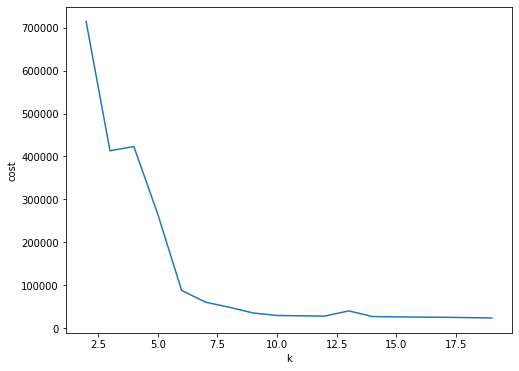

In [17]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Look like there is very little gain after k=12, so we stick to that choice when processing the full data set.

**Train the machine learning model**

In [18]:
k = 12
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.00511527 -9.59192927 10.20398776]
[-8.79877678  7.30752724  2.00242494]
[ 2.49175762 -6.42520616 -7.47580024]
[-6.3221623  -3.89627988  0.56177749]
[ 0.27991887  1.81322325 -9.14288007]
[ 6.64357607 -5.69151668 -6.26962695]
[ 4.21882874 -9.63148782  8.61137489]
[-1.31238277 -4.21721709  2.23366874]
[ 1.58723305 -7.40642216 -6.41570149]
[-7.22603128 -4.18231902 -2.7139529 ]
[-0.90157747  5.71691605 -5.97326952]
[-2.46074836  9.0641161   4.6330292 ]


**Assign clusters to event**

We need to assign the individual rows to the nearest cluster centroid. That can be done with the transform method, which adds 'prediction' column to the dataframe. The prediction value is an integer between 0 and k, but it has no correlation to the y value of the input.

In [19]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id='row0', prediction=9), Row(id='row1', prediction=10), Row(id='row2', prediction=1)]


From the rows returned by the collect method create a new dataframe using our SQL context.

In [20]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-----+----------+
|   id|prediction|
+-----+----------+
| row0|         9|
| row1|        10|
| row2|         1|
| row3|        10|
| row4|         3|
| row5|        11|
| row6|         5|
| row7|        11|
| row8|         7|
| row9|         5|
|row10|         3|
|row11|         4|
|row12|         9|
|row13|         1|
|row14|         2|
|row15|         9|
|row16|         1|
|row17|        10|
|row18|         2|
|row19|         7|
+-----+----------+
only showing top 20 rows



Join the prediction with the original data

In [21]:
df_pred = df_pred.join(df, 'id')
df_pred.show()

+-----+----------+------------+----------+----------+
|   id|prediction|           x|         y|         z|
+-----+----------+------------+----------+----------+
| row0|         9|  -6.0776997|-2.9096103|-1.5181729|
| row1|        10|  -1.0122601|  7.322841|-5.4424076|
| row2|         1|   -8.297007| 6.3228936| 1.1672047|
| row3|        10|  -3.5071216|  4.784812|-5.4449472|
| row4|         3|   -5.122823|-3.3220499|-0.5069805|
| row5|        11|  -2.4764006|  8.255791|  4.409478|
| row6|         5|   7.3153954| -5.079449| -7.291215|
| row7|        11|  -2.0167463|  9.303454|  7.095179|
| row8|         7|  -0.2338185| -4.892681| 2.1228876|
| row9|         5|    6.565442| -6.855994|-6.7983212|
|row10|         3|  -5.6902847|-6.4827404|-0.9246967|
|row11|         4|-0.017986143| 2.7632365| -8.814824|
|row12|         9|  -6.9042625|-6.1491723|-3.5354295|
|row13|         1|  -10.389865|  9.537853|  0.674591|
|row14|         2|   3.9688683|-6.0467844| -5.462389|
|row15|         9|   -7.3370

Convert to Pandas dataframe

In [22]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row0,9,-6.077700,-2.909610,-1.518173
row1,10,-1.012260,7.322841,-5.442408
row2,1,-8.297007,6.322894,1.167205
row3,10,-3.507122,4.784812,-5.444947
row4,3,-5.122823,-3.322050,-0.506980


Visualize the results

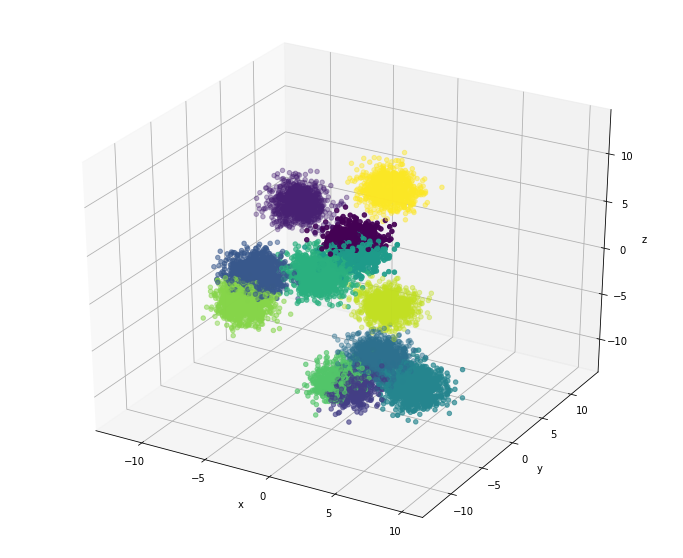

In [23]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()



---



**Classification Example**

Download the dataset into the colab

In [24]:
import os
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/MingChen0919/learning-apache-spark/master/data/WineData.csv', 'WineData2.csv')

('WineData2.csv', <http.client.HTTPMessage at 0x7f58c570a750>)

In [25]:
!ls

input.csv    spark-2.4.7-bin-hadoop2.7	    WineData2.csv
sample_data  spark-2.4.7-bin-hadoop2.7.tgz


Load dataset

In [26]:
df1 = spark.read.format("csv").option("header", "true").load("WineData2.csv")
df1.show(5)
df1.printSchema()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|          0|           1.9|    0.076|                 11|                  34| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|          0|           2.6|    0.098|                 25|                  67| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|                 15|                  54|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|                 17|           

In [27]:
COLS = ['fixed','volatile','citric','sugar','chlorides','free','total','density','pH','sulphates','alcohol','quality']

Convert all data columns to float

In [28]:
for col in df1.columns:
    if col in COLS:
        df1 = df1.withColumn(col,df1[col].cast('float'))
df1.show()
df1.printSchema()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|          0|           1.9|    0.076|                 11|                  34| 0.9978|3.51|     0.56|    9.4|    5.0|
|          7.8|            0.88|          0|           2.6|    0.098|                 25|                  67| 0.9968| 3.2|     0.68|    9.8|    5.0|
|          7.8|            0.76|       0.04|           2.3|    0.092|                 15|                  54|  0.997|3.26|     0.65|    9.8|    5.0|
|         11.2|            0.28|       0.56|           1.9|    0.075|                 17|           

In [29]:
# Convert to float format
def string_to_float(x):
    return float(x)


def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

df1 = df1.withColumn("quality", quality_udf("quality"))

df1.show(5,True)
df1.printSchema()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|          0|           1.9|    0.076|                 11|                  34| 0.9978|3.51|     0.56|    9.4| medium|
|          7.8|            0.88|          0|           2.6|    0.098|                 25|                  67| 0.9968| 3.2|     0.68|    9.8| medium|
|          7.8|            0.76|       0.04|           2.3|    0.092|                 15|                  54|  0.997|3.26|     0.65|    9.8| medium|
|         11.2|            0.28|       0.56|           1.9|    0.075|                 17|           

**Transform the dataset to DataFrame**

In [30]:
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [31]:
transformed = transData(df1)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



**Deal with Categorical Label and Variables**

Index labels, adding metadata to the label column

In [32]:
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



Automatically identify categorical features, and index them.
Set maxCategories so features with > 4 distinct values are treated as continuous.

In [33]:
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



Split the data to training and test data sets

In [34]:
(trainingData, testData) = transformed.randomSplit([0.7, 0.3])

trainingData.show(5,False)
testData.show(5,False)

+------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                      |label |
+------------------------------------------------------------------------------------------------------------------------------+------+
|[4.6,0.52,0.15,2.1,0.05400000140070915,8.0,65.0,0.993399977684021,3.9000000953674316,0.5600000023841858,13.100000381469727]   |low   |
|[4.7,0.6,0.17,2.3,0.057999998331069946,17.0,106.0,0.9932000041007996,3.8499999046325684,0.6000000238418579,12.899999618530273]|medium|
|[5.0,0.38,0.01,1.6,0.04800000041723251,26.0,60.0,0.9908400177955627,3.700000047683716,0.75,14.0]                              |medium|
|[5.0,0.4,0.5,4.3,0.04600000008940697,29.0,80.0,0.9901999831199646,3.490000009536743,0.6600000262260437,13.600000381469727]    |medium|
|[5.0,0.74,0.0,1.2,0.04100000113248825,16.0,46.0

Fit Multinomial logisticRegression Classification Model

In [35]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

**Pipeline Architecture**

Convert indexed labels back to original labels.

In [36]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

Chain indexers and tree in a Pipeline

In [37]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

Train model.  This also runs the indexers.

In [38]:
model = pipeline.fit(trainingData)

Make predictions

In [39]:
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[4.9,0.42,0.0,2.1...| high|          high|
|[5.0,0.42,0.24,2....| high|          high|
|[5.1,0.51,0.18,2....| high|        medium|
|[5.1,0.585,0.0,1....| high|        medium|
|[5.4,0.42,0.27,2....| high|        medium|
+--------------------+-----+--------------+
only showing top 5 rows



**Evaluation**

In [40]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.823651
Test Error = 0.176349


**Visualization**

In [41]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)



**Confusion matrix**

In [43]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=list(class_names))
cnf_matrix

array([[376,   7,   0],
       [ 59,  21,   0],
       [ 19,   0,   0]])

Plot non-normalized confusion matrix

Confusion matrix, without normalization
[[376   7   0]
 [ 59  21   0]
 [ 19   0   0]]


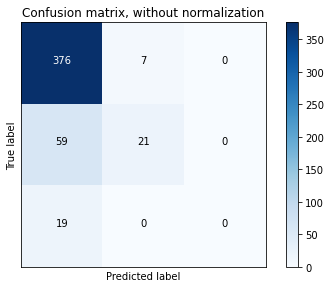

In [44]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(class_names),
                      title='Confusion matrix, without normalization')
plt.show()

Plot normalized confusion matrix

Normalized confusion matrix
[[0.98172324 0.01827676 0.        ]
 [0.7375     0.2625     0.        ]
 [1.         0.         0.        ]]


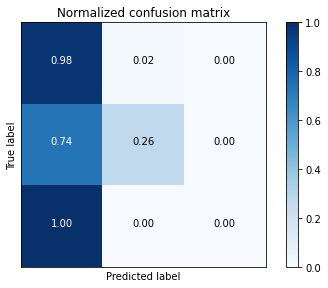

In [45]:

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(class_names), normalize=True,
                      title='Normalized confusion matrix')

plt.show()